In [1]:
# import necessary packages for geospatial analysis and data processing

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

print("Packages imported successfully!")

Packages imported successfully!


In [2]:
# Osprey nests data
osprey_nests_df = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Outages, 2018-Current')

# Convert pandas DataFrame to GeoDataFrame
osprey_nests_df = gpd.GeoDataFrame(osprey_nests_df, geometry=gpd.points_from_xy(osprey_nests_df.faultlongitude, osprey_nests_df.faultlatitude))

# Outages data
outages_df = gpd.read_file('CapstoneData/Outages01012020through09012023.csv')

# Confirmed nests data
osprey_confirmed_nests = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Confirmed Osprey Nests')

# Map data
map_data = gpd.read_file('CapstoneData/NY_Waterbody_List.geojson')


In [3]:
# remove rows from outages_df where 'CauseDesc' is 'Animal - Bird Contact'
outages_df = outages_df[outages_df.CauseDesc != 'Animal - Bird Contact']

In [4]:
outages_df.shape

(175523, 93)

In [5]:
grouped_outages = outages_df.groupby('OPCO')

# Create separate DataFrames for each group
outages_by_opco = {opco: group for opco, group in grouped_outages}

outages_nyseg = outages_df[outages_df.OPCO=='NYSEG']
outages_rge = outages_df[outages_df.OPCO=='RGE']
outages_cmp = outages_df[outages_df.OPCO=='CMP']
outages_ui = outages_df[outages_df.OPCO=='UI']

outages_cmp

,OPCO,Incident,IncSeqNo,OPCOIncStartNo,GroupNo,MalfStartDate,MalfStartTime,MalfEndDate,MalfEndTime,Duration,...,faultlongitude,ServiceCenter,ECC_OperatorLog,ThirdPartyAttacher,UI_TREE_CONTACT_TYPE_DESC,FaultFlocAlgoSource,DerivedFaultCircuit,WeatherIndex,iCDSOutageRemark,geometry
23,CMP,876687,1,672777,NULL,9/1/2023,6:27:00,9/1/2023,7:36:00,1.15,...,-70.299745,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,416D1,22,NULL,None
25,CMP,876688,1,672784,NULL,9/1/2023,8:12:00,9/1/2023,8:56:00,0.7333,...,-69.781802,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,240D1,17,NULL,None
27,CMP,876689,1,672783,NULL,9/1/2023,8:09:00,9/1/2023,9:00:00,0.85,...,-70.777591,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,626D1,32,NULL,None
29,CMP,876690,1,672781,NULL,9/1/2023,7:58:00,9/1/2023,9:19:00,1.35,...,-69.2713,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,837D1,22,NULL,None
31,CMP,876691,1,672788,NULL,9/1/2023,8:37:00,9/1/2023,9:58:00,1.35,...,-70.190537,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,620D3,18,NULL,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177030,CMP,605147,0,108585,NULL,1/1/2020,3:10:00,1/1/2020,5:15:00,2.083333333,...,-69.52255,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,219D2,47,NULL,None
177031,CMP,605148,0,108588,NULL,1/1/2020,7:21:00,1/1/2020,8:26:00,1.083333333,...,-70.76773,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,661D1,28,NULL,None
177032,CMP,605149,0,108594,NULL,1/1/2020,8:03:00,1/1/2020,8:39:00,0.6,...,-69.951912,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,256D2,35,NULL,None
177033,CMP,605150,0,108589,NULL,1/1/2020,7:23:00,1/1/2020,8:56:00,1.55,...,-70.787968,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,602D3,27,NULL,None


In [6]:
#  only choose columns 'OPCO', 'CustomerCount', CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude' from outages_cmp
outages_cmp = outages_cmp[['OPCO', 'CustomerCount', 'CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude']]
# Filter out records with missing longitude or latitude values
outages_cmp = outages_cmp[(outages_cmp['faultlongitude'] != '') & (outages_cmp['faultlatitude'] != '')]
# Replace empty strings with NaN
outages_cmp['faultlongitude'] = outages_cmp['faultlongitude'].replace('', np.nan)
outages_cmp['faultlatitude'] = outages_cmp['faultlatitude'].replace('', np.nan)

outages_cmp['faultlongitude'] = outages_cmp['faultlongitude'].replace('NULL', np.nan)
outages_cmp['faultlatitude'] = outages_cmp['faultlatitude'].replace('NULL', np.nan)

# Drop rows with NaN values
outages_cmp = outages_cmp.dropna(subset=['faultlongitude', 'faultlatitude'])

outages_cmp.shape

(66003, 7)

In [7]:
outages = outages_cmp

In [8]:
grouped_nests = osprey_nests_df.groupby('OPCO')

# Create separate DataFrames for each group
osprey_nests_by_opco = {opco: group for opco, group in grouped_nests}

nests_nyseg = osprey_nests_df[osprey_nests_df.OPCO=='NYSEG']
nests_rge = osprey_nests_df[osprey_nests_df.OPCO=='RGE']
nests_cmp = osprey_nests_df[osprey_nests_df.OPCO=='CMP']
nests_ui = osprey_nests_df[osprey_nests_df.OPCO=='UI']

In [9]:
osprey_nests = nests_cmp

In [10]:
# only choose columns 'CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude' from osprey_nests
osprey_nests = osprey_nests[['CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude']]
# Filter out records with missing longitude or latitude values
osprey_nests = osprey_nests[(osprey_nests['faultlongitude'] != '') & (osprey_nests['faultlatitude'] != '')]
# Replace empty strings with NaN
osprey_nests['faultlongitude'] = osprey_nests['faultlongitude'].replace('', np.nan)
osprey_nests['faultlatitude'] = osprey_nests['faultlatitude'].replace('', np.nan)
# Drop rows with NaN values
osprey_nests = osprey_nests.dropna(subset=['faultlongitude', 'faultlatitude'])

osprey_nests.shape

(4566, 6)

In [11]:
# Create geometry columns for outages and osprey nests datasets using the longitude and latitude
outages['geometry'] = gpd.points_from_xy(pd.to_numeric(outages.faultlongitude, errors='coerce'), pd.to_numeric(outages.faultlatitude, errors='coerce'))
osprey_nests['geometry'] = gpd.points_from_xy(pd.to_numeric(osprey_nests.faultlongitude, errors='coerce'), pd.to_numeric(osprey_nests.faultlatitude, errors='coerce'))

In [12]:
from shapely.geometry import Point

# Convert pandas DataFrame to GeoDataFrame
outages = gpd.GeoDataFrame(outages, geometry=gpd.points_from_xy(outages.faultlongitude, outages.faultlatitude))
osprey_nests = gpd.GeoDataFrame(osprey_nests, geometry=gpd.points_from_xy(osprey_nests.faultlongitude, osprey_nests.faultlatitude))

In [13]:
# Ensure data is using the correct coordinate reference system (CRS)
outages = outages.set_crs(epsg=4326)
osprey_nests = osprey_nests.set_crs(epsg=4326)

In [14]:
import geopandas as gpd
from shapely.geometry import Point
from multiprocessing import Pool
# buffer needs to be in correct coordinate reference system. it is typically calculated in m on the backend, so doing an
# osprey_nests.to_crs(crs=3857) should remove the first warning.
osprey_nests_m = osprey_nests.to_crs(crs=3857)
outages = outages.to_crs(crs=3857)
osprey_buffer = osprey_nests_m.buffer(distance=5000)
print('done')
osprey_buffer_df = gpd.GeoDataFrame(geometry=osprey_buffer)
print(osprey_buffer_df.shape)
print(outages.shape)

# Assume you have a function for the spatial join
def spatial_join_chunk(chunk):
    return gpd.sjoin(chunk['outages'], chunk['osprey_buffer_df'], how='inner', predicate='intersects')
arg = {'outages':outages,'osprey_buffer_df':osprey_buffer_df}

# change coordinates back to original crs
outages_near_nests = spatial_join_chunk(arg).to_crs(crs=4326)
print(outages_near_nests)

done
(4566, 1)
(66003, 8)
       OPCO CustomerCount CircuitVoltage    Division  \
23      CMP            12          12470    Lewiston   
3440    CMP          1048          12470    Lewiston   
3589    CMP           423          12470    Lewiston   
3590    CMP           625          12470    Lewiston   
3591    CMP            55          12470    Lewiston   
...     ...           ...            ...         ...   
158986  CMP             3          12470  Farmington   
167521  CMP             3          12470  Farmington   
167537  CMP             2          12470  Farmington   
168048  CMP          1465          12470  Farmington   
170588  CMP             3          12470  Farmington   

                             CauseDesc faultlatitude faultlongitude  \
23          Cause Unknown/Undetermined     43.881638     -70.299745   
3440          Pole Damage MVA/Non-Util     43.889789     -70.291757   
3589          Pole Damage MVA/Non-Util     43.889789     -70.291757   
3590          Pol

In [21]:
outages_distance_to_water = pd.read_csv('CapstoneData/outages_with_waterbody_distances_CMP.csv')

In [22]:
# remove rows from outages_distance_to_water where 'CauseDesc' is 'Animal - Bird Contact'
outages_distance_to_water = outages_distance_to_water[outages_distance_to_water.CauseDesc != 'Animal - Bird Contact']

In [23]:
outages_distance_to_water['nearest_waterbody_distance_km'].describe()

count    66003.000000
mean         2.833505
std          1.879110
min          0.015773
25%          1.494414
50%          2.402997
75%          3.700646
max         14.649700
Name: nearest_waterbody_distance_km, dtype: float64

In [24]:
# Convert latitude and longitude columns to a GeoDataFrame
outages_distance_to_water['geometry'] = gpd.GeoSeries(
    [Point(xy) for xy in zip(outages_distance_to_water['faultlongitude'], outages_distance_to_water['faultlatitude'])]
)

In [27]:
# Define categories based on conditions
outages_distance_to_water['near_water'] = np.where(outages_distance_to_water['nearest_waterbody_distance_km'] <= 2, 'NW', 'AW')
outages_distance_to_water['near_nest'] = np.where(outages_distance_to_water.index.isin(outages_near_nests.index), 'NN', 'AN')
print(outages_distance_to_water['near_water'].value_counts())
print(outages_distance_to_water['near_nest'].value_counts())

# Assign risk labels based on the desired categories
def assign_risk_label(row):
    if row['near_water'] == 'NW' and row['near_nest'] == 'AN':
        return 'High'
    elif (row['near_water'], row['near_nest']) in [('NW', 'NN'), ('AW', 'AN')]:
        return 'Medium'
    else:
        return 'Low'

outages_distance_to_water['risk'] = outages_distance_to_water.apply(assign_risk_label, axis=1)


AW    39814
NW    26189
Name: near_water, dtype: int64
AN    45628
NN    20375
Name: near_nest, dtype: int64


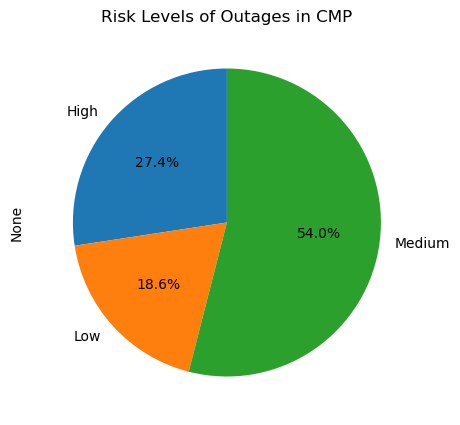

Medium    35633
High      18092
Low       12278
Name: risk, dtype: int64


In [28]:
# create pie chart for risk levels
import matplotlib.pyplot as plt

risk_levels = outages_distance_to_water.groupby('risk').size()
risk_levels.plot.pie(y='risk', figsize=(5, 5), autopct='%1.1f%%', startangle=90, title='Risk Levels of Outages in CMP')
plt.show()

# Count the number of confirmed osprey nests in each risk category
confirmed_nests_risk_counts = outages_distance_to_water['risk'].value_counts()
print(confirmed_nests_risk_counts)

In [31]:
# convert outages_distance_to_water to csv
outages_distance_to_water.to_csv('CapstoneData/risk_categories_CMP.csv', index=False)